# Home Credit Risk : Pre-Processing, Feature Engineering and Data Modelling


The last notebook covered an in-depth EDA of the various data files for this problem.

In this notebook, we will proceed on to do pre-processing on our Home credit Data. After we have the processed data, we will be creating new and improved features using the inferences we had made during our EDA.

Finally, once we have the training and test data ready, we will be training various models and assess the performance of each using the AUC Score metric and also find out additional information like feature importance, the feasibility of deploying such a model, etc.

So, let's get started.


## Importing libraries and downloading the Data

In [ ]:
# Importing all the required libraries for the task
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import gc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
import itertools

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7,hi;q=0.6" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/9120/860599/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1616213617&Signature=NJZK0lChWajtMo3H0gcwtVBQMbTvgUfdXbeGyUlSHO87MNPUZtx4%2FF4lLLpwO00M2tfsUMRoo1tiSHrZBVmEYq7OXK7Ixm6P6FZDzTcO45Vd2OfuIRnONLisTmW6KYIT5%2BC7afEecQjGeAlVm9b9K5zpQHlWVfrxqheP8Zoq7cTcR44JvT%2FSHLUTZHHRPRKnocoRoTFYm8D5MnHWAeizXZw6dZqvoi76EL0C77z1hik8QZz0%2BWZREanJl3etM10H%2FLiEZmVkoe2A6X8ReO49V0mFWHxW0VCgdEYbtrAycw%2FkzgeyIFGxgw46vFy%2FLcGvVGpo0yKHqqknweqVPKSENQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dhome-credit-default-risk.zip" -c -O 'home-credit-default-risk.zip'

--2021-03-20 04:49:36--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/9120/860599/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1616213617&Signature=NJZK0lChWajtMo3H0gcwtVBQMbTvgUfdXbeGyUlSHO87MNPUZtx4%2FF4lLLpwO00M2tfsUMRoo1tiSHrZBVmEYq7OXK7Ixm6P6FZDzTcO45Vd2OfuIRnONLisTmW6KYIT5%2BC7afEecQjGeAlVm9b9K5zpQHlWVfrxqheP8Zoq7cTcR44JvT%2FSHLUTZHHRPRKnocoRoTFYm8D5MnHWAeizXZw6dZqvoi76EL0C77z1hik8QZz0%2BWZREanJl3etM10H%2FLiEZmVkoe2A6X8ReO49V0mFWHxW0VCgdEYbtrAycw%2FkzgeyIFGxgw46vFy%2FLcGvVGpo0yKHqqknweqVPKSENQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dhome-credit-default-risk.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.139.128, 74.125.141.128, 173.194.210.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.139.128|:443... connected.
HTTP request sent, awaiting response... 400 Bad Request
2021-03-20 04:49:36 ERROR 400: Bad Request.



In [ ]:
# Un-Zip the data
!unzip 'home-credit-default-risk.zip' -d '/data'

Archive:  home-credit-default-risk.zip
  inflating: /data/HomeCredit_columns_description.csv  
  inflating: /data/POS_CASH_balance.csv  
  inflating: /data/application_test.csv  
  inflating: /data/application_train.csv  
  inflating: /data/bureau.csv        
  inflating: /data/bureau_balance.csv  
  inflating: /data/credit_card_balance.csv  
  inflating: /data/installments_payments.csv  
  inflating: /data/previous_application.csv  
  inflating: /data/sample_submission.csv  


## Helper Functions

### 1. Reducing the memory Usage 

Reference : https://www.kaggle.com/aantonova/797-lgbm-and-bayesian-optimization


In [ ]:
# This function will help reduce memory usage while loading a data file into memory.
def reduce_mem_usage(data, verbose = True):
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return data

### 2. One Hot Encoding

In [ ]:
def one_hot_encoder(df, nan_category = True):
    # List of all original Columns in the dataframe
    original_columns = list(df.columns)
    # List of all categorical features
    categorical_columns = list(df.select_dtypes('object').columns)
    # Doing one-hot encoding for categorical features
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_category)
    # Creating a list of new column names for better reference. 
    new_columns = [col for col in df.columns if col not in original_columns]
    return df, new_columns

### 3. Create Polynomial Features

In [ ]:
# Creating some new features from the EXT_SOURCE features. 
def create_poly_features(df, degree = 3):
  '''
  The main aim of this function is to create polynomial features
  for the given data frame columns. 

  Input :
    1. df : The dataframe with the columns for which you want to create polynomial features.
    2. degree : Degree of polynomials you want as features. (default : 3)
  Output :
    1. df : dataframe with all the polynomial features. 
  '''
  print('Shape of the Dataframe before Polynomial Features : ',df.shape)
  print('Featurization will be done for the following features:')
  print(df.columns)
  print('-'*100)

  # Handling all the missing values.
  mean_impute = SimpleImputer(missing_values=np.nan ,strategy = 'mean')
  poly_fea = PolynomialFeatures(degree = degree)

  # Performing fit on Train data
  df_train = df[df['TARGET'].notnull()]
  df_test = df[df['TARGET'].isnull()]

  features_train = df_train.drop(columns = ['TARGET'])
  features_test = df_test.drop(columns = ['TARGET'])

  features_train = features_train.fillna(features_train.mean())
  features_test = features_test.fillna(features_train.mean())

  # Polynomial Featurization
  print('Featurizing the data......')
  poly_fea.fit(features_train)

  poly_features_train = poly_fea.transform(features_train)
  poly_features_test = poly_fea.transform(features_test)
  print('Done!')
  print('-'*100)
  
  poly_features = pd.DataFrame(poly_features_train, columns = poly_fea.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2','EXT_SOURCE_3']))
  poly_features_test = pd.DataFrame(poly_features_test, columns = poly_fea.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2','EXT_SOURCE_3']))

  merged_data = pd.concat([poly_features, poly_features_test], axis = 0, ignore_index = True)
  print('Shape after featurization :', merged_data.shape)

  return merged_data


### 4. Create Division based Features

In [ ]:
def create_div_features(df, div_features_list, data_file_name):
  '''
  This function will help us Division based features
  from the primary features. 

  Input:
    df: Dataframe all the features
    div_features_list : list of all features you want division features for.
    data_file_name : Name of the data file for which these features are created.

  Output:
    df : df with all the newly created features.
  '''
  # Now, we will move on to create the wanted features. We will create pair of all features
  feature_pairs_div =  list(itertools.permutations(div_features_list,2))

  # Creating new features
  for f1,f2 in feature_pairs_div:
    # new feature name
    f_name = data_file_name + '_' + f1 + '_' + f2 + '_div' 
    df[f_name] = df[f1] / df[f2]

  return df

### 5. Create Subtraction Features

In [ ]:
def create_sub_features(df, sub_features_list, data_file_name):
  '''
  This function will help us Substraction based features
  from the primary features. 

  Input:
    df: Dataframe all the features
    sub_features_list : list of all features you want substraction features for
    data_file_name : Name of the data file

  Output:
    df : df with all the newly created features.
  '''
  # Now, we will move on to create the wanted features. We will create pair of all features
  feature_pairs_div =  list(itertools.permutations(sub_features_list,2))

  # Creating new features
  for f1,f2 in feature_pairs_div:
    # new feature name
    f_name = data_file_name + '_' + f1 + '_' + f2 + '_sub' 
    df[f_name] = df[f1] - df[f2]

  return df

## 1. Application_train and Application_test

In [ ]:
# Loading the data files
print('Loading Data Files.....')
start = time()
directory = '../data/'
app_train = pd.read_csv(directory+'application_train.csv')
app_test = pd.read_csv(directory+'application_test.csv')
print('It took {} seconds to load the data.'.format(round(time() - start), 2))

Loading Data Files.....
It took 5 seconds to load the data.


### Data Pre processing and Feature Engineering 

In this step, we will do the following:

1. Handle all the missing values in the data set.
2. Remove outliers from data. We will do this according to the reference notebooks we refered. 
3. Remove all the columns who do not help us with our classification. 
4. Creating some new features.

In [ ]:
# We will first merge the 2 data files so we have to perform these steps only once. 
merged_data = pd.concat([app_train, app_test], axis = 0, ignore_index = True)
# Printing the shape of merged data
print(merged_data.shape)
# Please know that we will have null values for target of the test data. 
print('Number of null values in the TARGET column :',merged_data['TARGET'].isnull().sum())


(356255, 122)
Number of null values in the TARGET column : 48744


In [ ]:
# First, removing the XNA gender category. It only has 4 occurences. 
merged_data.drop(merged_data[merged_data['CODE_GENDER'] == 'XNA'].index, inplace = True)
# Second, there is 'Maternity Leave' category in Income_type. We remove that.
merged_data.drop(merged_data[merged_data['NAME_INCOME_TYPE'] == 'Maternity leave'].index, inplace = True)
# Finally, there is a Unknown category in FAMILY_STATUS, which we do not want. 
merged_data.drop(merged_data[merged_data['NAME_FAMILY_STATUS'] == 'Unknown'].index, inplace = True)

# After this, we will remove some redundant or useless data. For instance, from several discussion it is seen that most FLAG_DOCUEMENT features are not useful.
# So, we will remove them. 
merged_data.drop(['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 
        'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 
        'FLAG_DOCUMENT_21'], axis = 1, inplace = True)

# Next, we will replace some outliers from our data with NAN values.

# 1. A specific value for days employed. (gives you around 1000 years, which is not possible)
merged_data['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)

# 2. OWN_CAR_AGE is greater than 70 years will be replaced with Nan. Only 3 instances. 70 as max age of applicant is 70
merged_data.loc[merged_data['OWN_CAR_AGE'] > 70, 'OWN_CAR_AGE'] = np.nan
# 3. The only possible values for regoin rating are 1,2,3 according to feature description. But there is a -1 value too so we remove that.
merged_data.loc[merged_data['REGION_RATING_CLIENT_W_CITY'] == -1, 'REGION_RATING_CLIENT_W_CITY'] = np.nan
# 4. AMT_INCOME Total greater than 10,000,000 (10 million) is highly unlikely (to default or in general). So, replace it
merged_data.loc[merged_data['AMT_INCOME_TOTAL'] > 1e7, 'AMT_INCOME_TOTAL'] = np.nan
# Some more outliers based on discussions.
merged_data.loc[merged_data['AMT_REQ_CREDIT_BUREAU_QRT'] > 10, 'AMT_REQ_CREDIT_BUREAU_QRT'] = np.nan
merged_data.loc[merged_data['OBS_30_CNT_SOCIAL_CIRCLE'] > 40, 'OBS_30_CNT_SOCIAL_CIRCLE'] = np.nan

# one hot encoding all the categorical features.
merged_data, new_cat_columns = one_hot_encoder(merged_data, nan_category = True)

Now that we are done with the pre processing part, we will now move on to the most important process, <b> Feature Engineering!</b>

We will focus on a lot of domain specific features we learn abour from kernels and blogs and also try to create some of our own features based on our knowledge and logic.

We will focus largely on the EXT_SOURCE features as they have a high correlation to the TARGET variable. We will create Aggregate features for all these 3. 

In [ ]:
df_ext = merged_data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3' , 'TARGET']]
df_ext = create_poly_features(df_ext)

# removing the primary column features from the data
df_ext = df_ext.drop(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', '1'], axis = 1)
merged_data = pd.concat([merged_data, df_ext], axis = 1)

Shape of the Dataframe before Polynomial Features :  (356244, 4)
Featurization will be done for the following features:
Index(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TARGET'], dtype='object')
----------------------------------------------------------------------------------------------------
Featurizing the data......
Done!
----------------------------------------------------------------------------------------------------
Shape after featurization : (356244, 20)


In [ ]:
# These were some features used by the first place solution of the contest.
merged_data['credit_downpayment'] =  merged_data['AMT_GOODS_PRICE'] - merged_data['AMT_CREDIT']
merged_data['AGE_int'] =  pd.to_numeric((merged_data['DAYS_BIRTH'] / -365), downcast='integer')

In [ ]:
# Creating Division based Features for AMT_ features of app_train/test data
import itertools
fea_list = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'OWN_CAR_AGE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
print(merged_data.shape)
merged_data = create_div_features(merged_data, fea_list, 'app_data')
print('After Division Features')
print(merged_data.shape)

(356255, 266)
After Division Features
(356255, 356)


In [ ]:
print('The final application data has {} rows and {} features.'.format(merged_data.shape[0], merged_data.shape[1]))

The final application data has 356255 rows and 356 features.


This completes our Feature Engineering on application_train/test data! Next, we will look for some important features in Bureau Data

## 2. Bureau Data 

Next, we will create features from the credit bureau data info. This information provides us with the previous loan applications of each applicant to institutions other than Home Credit, as reported to the Credit Bureau. 

We have 2 data sources for this:

1. Bureau : This contains information about the applications. There are multiple loan applications for a single applicant, each identified by a unique SK_ID_BUREAU id. 

2. Bureau Balance : It contains monthly balance data about each of the previous loans.

We will first load the data files are then move on to create various features. 

In [ ]:
# Loading the data files
print('Loading Data Files.....')
start = time()
directory = '../data/'
bureau = reduce_mem_usage(pd.read_csv(directory+'bureau.csv'), verbose = False)
bureau_balance = reduce_mem_usage(pd.read_csv(directory+'bureau_balance.csv'), verbose = False)
print('It took {} seconds to load the data.'.format(round(time() - start), 2))

Loading Data Files.....
It took 8 seconds to load the data.


First, we will start with the bureau data. Please note that most of the features created in this are the ideas I got from refering various discussions, kernels and blogs.

But, I have tried to create my own logic by developing functions to generalize this process. For example, we will be creating mostly subtraction based features for this data, so I have created a function for this purpose. We will have some un- important features for now but e take care of them while feature selection which will only select the best features. 

First, we will start with a little pre processing to take care outliers and missing values from the data.

Info about the different columns of the data:

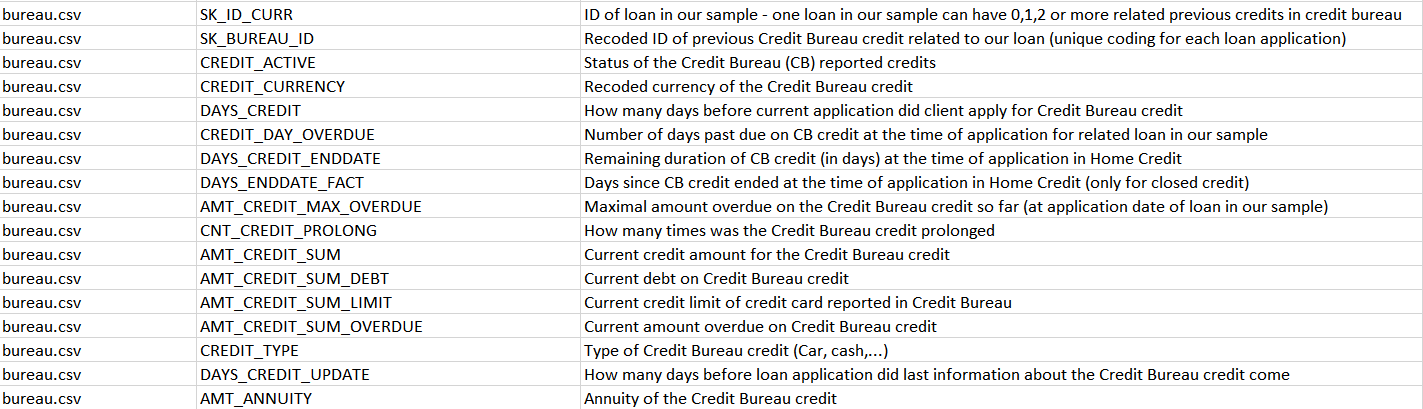

In [ ]:
# Taking care of outliers or missing values in the bureau data.
bureau.loc[bureau['AMT_ANNUITY'] > 1e8, 'AMT_ANNUITY'] = np.nan
bureau.loc[bureau['AMT_CREDIT_SUM'] > 1e8, 'AMT_CREDIT_SUM'] = np.nan
bureau.loc[bureau['AMT_CREDIT_SUM_DEBT'] > 1e8, 'AMT_CREDIT_SUM_DEBT'] = np.nan
bureau.loc[bureau['AMT_CREDIT_MAX_OVERDUE'] > .8e8, 'AMT_CREDIT_MAX_OVERDUE'] = np.nan
bureau.loc[bureau['DAYS_ENDDATE_FACT'] < -10000, 'DAYS_ENDDATE_FACT'] = np.nan
bureau.loc[(bureau['DAYS_CREDIT_UPDATE'] > 0) | (bureau['DAYS_CREDIT_UPDATE'] < -40000), 'DAYS_CREDIT_UPDATE'] = np.nan
bureau.loc[bureau['DAYS_CREDIT_ENDDATE'] < -10000, 'DAYS_CREDIT_ENDDATE'] = np.nan

# Lastly, we will remove all the rows where the the date for credit closing is at an earlier date compared to the application date, which is not possible.
bureau.drop(bureau[bureau['DAYS_ENDDATE_FACT'] < bureau['DAYS_CREDIT']].index, inplace = True)


Next, we will create subtraction based features for our bureau dataset. 

In [ ]:
# Creating substraction based features for DAYS_ and AMT_ Columns one after the other. 
amt_features = ['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_ANNUITY', 'AMT_CREDIT_MAX_OVERDUE']
print('-' * 100)
print('Shape before the subtraction based features for AMT_ features : ',bureau.shape)
bureau = create_sub_features(bureau, amt_features, 'bureau')
print('Shape after the subtraction based features for AMT_ features : ',bureau.shape)

day_features = ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']
print('-' * 100)
print('Shape before the subtraction based features for DAYS_ features : ',bureau.shape)
bureau = create_sub_features(bureau, day_features, 'bureau')
print('Shape after the subtraction based features for DAYS_ features : ',bureau.shape)


----------------------------------------------------------------------------------------------------
Shape before the subtraction based features for AMT_ features :  (1716320, 17)
Shape after the subtraction based features for AMT_ features :  (1716320, 47)
----------------------------------------------------------------------------------------------------
Shape before the subtraction based features for DAYS_ features :  (1716320, 47)
Shape after the subtraction based features for DAYS_ features :  (1716320, 59)


Next, we will do one hot encoding for categorical features.

In [ ]:
# One hot encoding for all categorical features. The function uses pandas get_dummies logic.
print('Shape before the one hot encoding : ',bureau.shape)
bureau, bureau_cat_columns = one_hot_encoder(bureau, nan_category = True)
print('Shape after the one hot encoding : ',bureau.shape)
print('After one hot encoding, there are {} new features'.format(len(bureau_cat_columns)))

Shape before the one hot encoding :  (1716320, 59)
Shape after the one hot encoding :  (1716320, 82)
After one hot encoding, there are 26 new features


This is all for the bureau data for now. We will come back to final feature engineering once we have created new features for the bureau balance data and then merged them to our bureau data by the SK_ID_CURR. 

Now, for the bureau balance data, we will mostly be creating aggregate features based on the SK_ID_BUREAU as we will get metrics for each loan of the applicant which will be very helpful to us.

We will also create some features based on the literature survey we did.

Here is what we know about this data file :

It has 3 columns: SK_ID_BUREAU, MONTHS_BALANCE and STATUS. STATUS is a categorical variable giving you the status of the loan. 

We are interested in the following features:

1. Aggregate features for monthly balance of each past loan (denoted by SK_ID_BUREAU)
2. one hot encoding of the STATUS feature


In [ ]:
# Creating Aggregate features and some features we have from our literature survey.

# Feature 1 : the first status for a particular loan
tmp = bureau_balance[['SK_ID_BUREAU', 'STATUS']].groupby('SK_ID_BUREAU')
tmp_last = tmp.last()
tmp_last.columns = ['First_status']
bureau_balance = bureau_balance.join(tmp_last, how = 'left', on = 'SK_ID_BUREAU')

# Feature 2 : The last status for a particular loan. 
tmp_first = tmp.first()
tmp_first.columns = ['Last_status']
bureau_balance = bureau_balance.join(tmp_first, how = 'left', on = 'SK_ID_BUREAU')

# Deleting the variables to free up the RAM.
del tmp, tmp_first, tmp_last

In [ ]:
# one hot encoding of the categorical variables.
bureau_balance, bureau_balance_cat = one_hot_encoder(bureau_balance, nan_category = True)

# Bureau balance: Perform aggregations 
aggregations = {}
for col in bureau_balance.columns:
    aggregations[col] = ['mean'] if col in bureau_balance_cat else ['min', 'max', 'size', 'std', 'mean']
    
bureau_balance = bureau_balance.groupby('SK_ID_BUREAU').agg(aggregations)
bureau_balance.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bureau_balance.columns.tolist()])

In [ ]:
# What are the number of features in bureau balance now
print('The bureau balance data has {} features now.'.format(bureau_balance.shape[1]))

The bureau balance data has 37 features now.


In [ ]:
# Bureau balance: merge with bureau.csv
bureau = bureau.merge(bureau_balance, how = 'left', on = 'SK_ID_BUREAU')
bureau.drop('SK_ID_BUREAU', axis = 1, inplace = True)

# Delete the bureau_balance data to free up memory
del bureau_balance

print(bureau.shape)

(1716320, 118)


In [ ]:
# Performing Aggregations on the overall data now. 
# Bureau and bureau_balance aggregations for bureau  dataset
categorical = bureau_cat_columns + bureau_balance_cat
aggregations = {}
print('Shape of the data before aggregation features : ', bureau.shape)

for col in bureau.columns:
    aggregations[col] = ['mean'] if col in categorical else ['std', 'mean', 'min', 'max']
bureau = bureau.groupby('SK_ID_CURR').agg(aggregations)
bureau.columns = pd.Index(['BUREAU_' + e[0] + "_" + e[1].upper() for e in bureau.columns.tolist()])

print('Shape of the data after aggregation features : ', bureau.shape)

Shape of the data before aggregation features :  (1716320, 118)
Shape of the data after aggregation features :  (305810, 394)


In [ ]:
# Store this data in a pickle file
pd.to_pickle(bureau, 'final_bureau_data.pkl')

This is all for the bureau data files. Next, we will move to the previous application data files. 

## 3. Previous Application Files

This data file contains all the information about the previous loan applications of the user with Home Credit. 

Each application is given a unique id SK_ID_PREV and there can be multiple SK_ID_PREV for a single SK_ID_CURR (the primary id). 

Let us start by loading the data.

In [ ]:
print('Loading Data Files.....')
start = time()
prev_app = reduce_mem_usage(pd.read_csv(directory+'previous_application.csv'), verbose = False)
print('It took {} seconds to load the data.'.format(round(time() - start), 2))

Loading Data Files.....
It took 9 seconds to load the data.


In [ ]:
# Replace some outliers
prev_app.loc[prev_app['AMT_CREDIT'] > 6000000, 'AMT_CREDIT'] = np.nan
prev_app.loc[prev_app['SELLERPLACE_AREA'] > 3500000, 'SELLERPLACE_AREA'] = np.nan
prev_app[['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 
             'DAYS_LAST_DUE', 'DAYS_TERMINATION']].replace(-365243, np.nan, inplace = True)

prev_app_id = prev_app[['SK_ID_CURR']]

Let us know a little more about the data. Like, the name of the features this data has and try to figure out how this information can be useful to us.


First, we will use our functions to create division and subtraction based features for the AMT and DAYS features as we did for the previous datasets.

In [ ]:
# Part 1 : Create Div Feature for AMT and DAYS Features
# i. AMT_ Features
amt_features_pre = ['AMT_ANNUITY','AMT_APPLICATION','AMT_CREDIT','AMT_DOWN_PAYMENT','AMT_GOODS_PRICE']
prev_app = create_div_features(prev_app, amt_features_pre, 'prev_app')
print('Shape after featurization of AMT_ Features : ',prev_app.shape)
print('-'*100)

# ii. DAYS_ Features
days_features_pre = ['DAYS_FIRST_DRAWING','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION', 'DAYS_DECISION']
prev_app = create_div_features(prev_app, days_features_pre, 'prev_app')
print('Shape after featurization of DAYS_ Features : ',prev_app.shape)

Shape after featurization of AMT_ Features :  (1670214, 57)
----------------------------------------------------------------------------------------------------
Shape after featurization of DAYS_ Features :  (1670214, 87)


In [ ]:
# Part 2 : Create subtraction Feature for AMT and DAYS Features
# i. AMT_ Features
amt_features_pre = ['AMT_ANNUITY','AMT_APPLICATION','AMT_CREDIT','AMT_DOWN_PAYMENT','AMT_GOODS_PRICE']
prev_app = create_sub_features(prev_app, amt_features_pre, 'prev_app')
print('Shape after featurization of AMT_ Features : ',prev_app.shape)
print('-'*100)

# ii. DAYS_ Features
days_features_pre = ['DAYS_FIRST_DRAWING','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION', 'DAYS_DECISION']
prev_app = create_sub_features(prev_app, days_features_pre, 'prev_app')
print('Shape after featurization of DAYS_ Features : ',prev_app.shape)

Shape after featurization of AMT_ Features :  (1670214, 107)
----------------------------------------------------------------------------------------------------
Shape after featurization of DAYS_ Features :  (1670214, 137)


In [ ]:
# One hot encoding the categorical variables
prev_app, prev_app_cat_features = one_hot_encoder(prev_app, nan_category = True)

In [ ]:
print('Shape after one hot Encoding :', prev_app.shape)

Shape after one hot Encoding : (1670214, 280)


In [ ]:
# Performing Aggregations for all the data
# Reference for idea : https://www.kaggle.com/aantonova/797-lgbm-and-bayesian-optimization
# Aggregations for the Previous Application Data
aggregations = {}
for col in prev_app.columns:
    aggregations[col] = ['mean'] if col in prev_app_cat_features else ['min', 'max', 'mean', 'std']

prev_app = prev_app.groupby('SK_ID_CURR').agg(aggregations)
prev_app.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_app.columns.tolist()])

print('Final Shape of the Previous applications data after featurization :', prev_app.shape)

Final Shape of the Previous applications data after featurization : (338857, 643)


## POS_Cash_Balance

This data is also related to the previous applications of the user, specifically for the cash loans and consumer credits. It has a monthly history for each of that specific loan application of a particular user. 

Hence, there will be multiple entries of balance info for a single SK_ID_PREV and there will be multiple SK_ID_PREV values for a single SK_ID_CURR.


In [ ]:
# Load the data
print('Loading Data Files.....')
start = time()
pos_cash = reduce_mem_usage(pd.read_csv(directory+'POS_CASH_balance.csv'), verbose = False)
print('It took {} seconds to load the data.'.format(round(time() - start), 2))

Loading Data Files.....
It took 6 seconds to load the data.


In [ ]:
# Reference : https://www.kaggle.com/aantonova/797-lgbm-and-bayesian-optimization
# Replace some anamolies from the data with nan values.
pos_cash.loc[pos_cash['CNT_INSTALMENT_FUTURE'] > 60, 'CNT_INSTALMENT_FUTURE'] = np.nan
    
# New features based on the domain knowledge
pos_cash['pos CNT_INSTALMENT more CNT_INSTALMENT_FUTURE'] = (pos_cash['CNT_INSTALMENT'] > pos_cash['CNT_INSTALMENT_FUTURE']).astype(int)
    
# One hot Encoding of all the categorical features.
pos_cash, pos_cash_cat_features = one_hot_encoder(pos_cash, nan_category = True)
    
# Aggregations for all the features based on the SK_ID_PREV. 
# mean agg for categorical (OHE) features
# (min, max, mean, std, sum) agg for all the other features
aggregations = {}
for col in pos_cash.columns:
    aggregations[col] = ['mean'] if col in pos_cash_cat_features else ['min', 'max', 'mean', 'std']
pos_cash = pos_cash.groupby('SK_ID_CURR').agg(aggregations)
pos_cash.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_cash.columns.tolist()])

# Count POS lines on the data for each SK_ID_CURR. (using groupby and size)
pos_cash['POS_COUNT'] = pos_cash.groupby('SK_ID_CURR').size()

# Print the final shape after featurization
print('Shape of the data after featurization : ',pos_cash.shape)

Shape of the data after featurization :  (337252, 43)


## Installments_payment

This data file contains the monthly payment history for each installment payed by the applicant. Here also, we will be creating Aggregate functions. But, from the survey done, Subtraction features would also be useful for our model. 

Hence, our featurization will include these 2 methods.

In [ ]:
# Load the data file
print('Loading Data Files.....')
start = time()
ins_pay = reduce_mem_usage(pd.read_csv(directory+'installments_payments.csv'), verbose = False)
print('It took {} seconds to load the data.'.format(round(time() - start), 2))

Loading Data Files.....
It took 12 seconds to load the data.


In [ ]:
ins_pay.dtypes.value_counts()

float16    3
int32      2
float32    2
int16      1
dtype: int64

In [ ]:
# Creating Subtraction features for AMT and DAYS feature
sub_features_list = ['NUM_INSTALMENT_VERSION','NUM_INSTALMENT_NUMBER','DAYS_INSTALMENT','DAYS_ENTRY_PAYMENT','AMT_INSTALMENT','AMT_PAYMENT']
ins_pay = create_sub_features(ins_pay, sub_features_list, 'INS_PAY')
print('Shape of the data after featurization : ',ins_pay.shape)

Shape of the data after featurization :  (13605401, 38)


In [ ]:
 ins_pay, ins_cat_features = one_hot_encoder(ins_pay, nan_category = True)

In [ ]:
# Next, we will create aggregate features
aggregations = {}
for col in ins_pay.columns:
    aggregations[col] = ['mean'] if col in ins_cat_features else ['min', 'max', 'mean', 'std']

ins_pay = ins_pay.groupby('SK_ID_CURR').agg(aggregations)
ins_pay.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in ins_pay.columns.tolist()])

print('Final Shape of the Previous applications data after featurization :', ins_pay.shape)

Final Shape of the Previous applications data after featurization : (339587, 152)


Now that this is complete too, we will move to our final data file, which deals with the monthly credit card related data for each applicant who has a Home Credit issued Credit Card.

## Credit_Card_Balance

In [ ]:
# Loading the data
print('Loading Data Files.....')
start = time()
credit_card = reduce_mem_usage(pd.read_csv(directory+'credit_card_balance.csv'), verbose = False)
print('It took {} seconds to load the data.'.format(round(time() - start), 2))

Loading Data Files.....
It took 9 seconds to load the data.


In [ ]:
# Creating Subtraction based features for the AMT_ and DPD_ Features
features_list = ['AMT_BALANCE','AMT_CREDIT_LIMIT_ACTUAL','AMT_DRAWINGS_ATM_CURRENT','AMT_DRAWINGS_CURRENT','AMT_DRAWINGS_OTHER_CURRENT','AMT_DRAWINGS_POS_CURRENT','AMT_INST_MIN_REGULARITY',
 'AMT_PAYMENT_CURRENT','AMT_PAYMENT_TOTAL_CURRENT','AMT_RECEIVABLE_PRINCIPAL','AMT_RECIVABLE','AMT_TOTAL_RECEIVABLE','SK_DPD','SK_DPD_DEF']

# passing these through our subtraction feature creation function
credit_card = create_sub_features(credit_card, features_list, 'CREDIT_CARD')
print('Shape after featurization : ', credit_card.shape)

Shape after featurization :  (3840312, 205)


In [ ]:
# One hot encoding for all the categorical features
credit_card, credit_card_cat_features = one_hot_encoder(credit_card, nan_category = True)
print('Shape after one hot encoding the data : ', credit_card.shape)

Shape after one hot encoding the data :  (3840312, 212)


In [ ]:
# Finally, performing the aggregation operations to get new features.
aggregations = {}
for col in credit_card.columns:
    aggregations[col] = ['mean'] if col in credit_card_cat_features else ['min', 'max', 'mean']

credit_card = credit_card.groupby('SK_ID_CURR').agg(aggregations)
credit_card.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in credit_card.columns.tolist()]) 

print('Final Shape of the credit card data after featurization :', credit_card.shape)

Final Shape of the credit card data after featurization : (103558, 620)


This completes the featurization of all the Data files! Now, for the last step in this notebook, we will merge them all into a single data file and divide them into train and test data.

## Merging the data files

In [ ]:
# Merging all the data files
df = merged_data.merge(bureau, how = 'left', on = 'SK_ID_CURR')
df = df.merge(prev_app, how = 'left', on = 'SK_ID_CURR')
df = df.merge(ins_pay, how = 'left', on = 'SK_ID_CURR')
df = df.merge(credit_card, how = 'left', on = 'SK_ID_CURR')
df = df.merge(pos_cash, how = 'left', on = 'SK_ID_CURR')

# Printing the shape of the final data
print('The final data shape : ', df.shape)

The final data shape :  (305810, 1852)


Now that we are finished with the Feature Engineering part of this project, we have the following data:

3,05,810 rows and 1,852 Features. 

Next step, using a very good clean data function I found while literature survey, I have used that to clean out our data by removing empty and correlated features before modelling the data.

In [ ]:
from lightgbm import LGBMClassifier
from scipy.stats import ranksums
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold

In [ ]:
# Reference : https://www.kaggle.com/aantonova/797-lgbm-and-bayesian-optimization

# Getting correlation values with respect to target variable
def corr_feature_with_target(feature, target):
    # Drop all na values for target 0 and 1 values of the feature
    c0 = feature[target == 0].dropna()
    c1 = feature[target == 1].dropna()
   
    if set(feature.unique()) == set([0, 1]):
        diff = abs(c0.mean(axis = 0) - c1.mean(axis = 0))
    else:
        diff = abs(c0.median(axis = 0) - c1.median(axis = 0))
        
    p = ranksums(c0, c1)[1] if ((len(c0) >= 20) & (len(c1) >= 20)) else 2
        
    return [diff, p]

def clean_data(data):
    warnings.simplefilter(action = 'ignore')
    
    # Removing empty features
    nun = data.nunique()  # Gets all the columns number of unique values
    empty = list(nun[nun <= 1].index)
    
    data.drop(empty, axis = 1, inplace = True)  # Dropping all features which are empty (0 unique values)
    print('After removing empty features there are {0:d} features'.format(data.shape[1]))
    
    # Removing features with the same distribution on 0 and 1 classes
    corr = pd.DataFrame(index = ['diff', 'p'])
    ind = data[data['TARGET'].notnull()].index
    
    # Loop through all the features
    for c in data.columns.drop('TARGET'):
        # Get corr value using our corr with respect to target function
        corr[c] = corr_feature_with_target(data.loc[ind, c], data.loc[ind, 'TARGET'])

    corr = corr.T
    corr['diff_norm'] = abs(corr['diff'] / data.mean(axis = 0))
    
    to_del_1 = corr[((corr['diff'] == 0) & (corr['p'] > .05))].index
    to_del_2 = corr[((corr['diff_norm'] < .5) & (corr['p'] > .05))].drop(to_del_1).index
    to_del = list(to_del_1) + list(to_del_2)
    if 'SK_ID_CURR' in to_del:
        to_del.remove('SK_ID_CURR')
        
    data.drop(to_del, axis = 1, inplace = True)
    print('After removing features with the same distribution on 0 and 1 classes there are {0:d} features'.format(data.shape[1]))
    
    # Removing features with not the same distribution on train and test datasets
    corr_test = pd.DataFrame(index = ['diff', 'p'])
    target = data['TARGET'].notnull().astype(int)
    
    for c in data.columns.drop('TARGET'):
        corr_test[c] = corr_feature_with_target(data[c], target)

    corr_test = corr_test.T
    corr_test['diff_norm'] = abs(corr_test['diff'] / data.mean(axis = 0))
    
    bad_features = corr_test[((corr_test['p'] < .05) & (corr_test['diff_norm'] > 1))].index
    bad_features = corr.loc[bad_features][corr['diff_norm'] == 0].index
    
    data.drop(bad_features, axis = 1, inplace = True)
    print('After removing features with not the same distribution on train and test datasets there are {0:d} features'.format(data.shape[1]))
    
    del corr, corr_test
    gc.collect()
    
    return data

In [ ]:
df = clean_data(df)

In [ ]:
pd.to_pickle(df, 'final_data_prev_bureau.pkl')

Now, we will start with data modelling. 

# Data Modelling

Now that we have our data, we will move on to modelling. In this section, we will first split the data into train and test datasets and then test the performance of different models on this datasets. 

### Importing the Required Libraries

In [ ]:
!pip install bayesian-optimization

In [ ]:
# Installing the Catboost model library
!pip install catboost

In [ ]:
# Libraries for processing the data and computing the performance.--
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import math
from math import log
import seaborn as sns
import re
# ------------------------------------------------------------------

# The models we will use for this study and optimizations ----------
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from bayes_opt import BayesianOptimization
# ------------------------------------------------------------------

In this part of the notebook, we will test different models on our data and see how each of them perform.
Before doing that, we need to get our data ready for the models. That processing will include:

*   Handling the missing and infinity values.
*   There are some overflowing values in the data.So, we will have to handle them too.
* Splitting the data into train, test and validation data such that each have a similar percentage of target 1 and 0 values. (Stratified Splitting)




### Getting the data ready for models

In [ ]:
# Splitting the data to train and test data and see the shapes
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

print('Train Data : ', train_df.shape)
print('Test Data : ', test_df.shape)

Train Data :  (307500, 1664)
Test Data :  (48755, 1664)


In [ ]:
test_df = test_df[test_df['SK_ID_CURR'].notnull()][:]
test_df.shape

(48744, 1664)

Now that we have our data ready, we are ready to train some models. We will be trying various different models on this data. 

We are going to test for the following models :

1. A baseline model (Dummy Classifer : strategy(Stratified))
2. Logistic Regression 
3. Random Forest
4. Light GBM 
5. XGBoost
6. CatBoost
7. Stacking Classifier



The next few steps are only for the simple Logistic Regression and Random Forest models. After experimenting with the data I found out that boosting based models perform better of raw data rather than standardised data. 


In [ ]:
# Getting the X and Y data for training
Y = train_df.pop('TARGET')
X = train_df

print(X.shape)
print(Y.shape)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, stratify = Y)

# Cleaning the data for infinite and overflowing values of both train and val data
X_train.replace([np.inf, -np.inf], np.nan, inplace=True) 
X_val.replace([np.inf, -np.inf], np.nan, inplace=True) 
X_train = X_train.where(X_train.values <= np.finfo(np.float64).max)
X_val = X_val.where(X_val.values <= np.finfo(np.float64).max)
X_train.fillna(X_train.median(), inplace = True)
X_val.fillna(X_val.median(), inplace = True)

# Cleaning the Test data
#test_df = test_df[test_df['SK_ID_CURR'].notnull()][:]
test_df.pop('TARGET')
test_df = test_df[features_to_train]
test_df.replace([np.inf, -np.inf], np.nan, inplace=True) 
test_df = test_df.where(test_df.values <= np.finfo(np.float64).max)
test_df.fillna(test_df.median(), inplace = True)

# Standardising the data
scaler = StandardScaler()

scaler.fit(X_train)
scaler_train = scaler.transform(X_train)
scaler_val = scaler.transform(X_val)
scaler.fit(test_df)
scaled_test = scaler.transform(test_df)

# Delete the original data to free up some memory
del X, Y

### Helper Functions

In [ ]:
# Function 1 : Predicting the values in Batches

def batch_predict(clf, data):
  
    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # The %1000 removes the excess data points to make the shape divisible by 1000 so we can loop through.
    # We will make a list of 1000 predictions each and store them in a parent list. (batch size = 1000)
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # Predicting and storing the values of the daata points we excluded for the looping. (this will have less than 1000 points)
    if data.shape[0]%1000 != 0:
      y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [ ]:
# Function 2 : Convert probablity to actual predictions for a given threshold
def predict(proba, threshold, fpr, tpr):
    
    t = threshold[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    # print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [ ]:
# Function 3 : Plot AUC Curve

def plot_roc_curve(y_true_train, y_pred_train, y_true_val, y_pred_val, model_name):
  '''
  This function let's you plot the ROC AUC curve.

  Inputs:
    y_true_train : True labels (groung truth) for train data
    y_pred_train : the predictions for train data (probablity predictions)
    y_true_val : True labels (groung truth) for validation data
    y_pred_val : the predictions for validation data (probablity predictions)
    model_name : Name of the model
  
  Output:
    Returns :
      train thresholds, fpr and tpr (train_params : type is dictionary)
      val thresholds, fpr and tpr (val_params : type is dictionary)
  '''
  # Getting the roc curve parameters
  train_fpr, train_tpr, train_thresholds = roc_curve(y_true_train, y_pred_train)
  val_fpr, val_tpr, val_thresholds = roc_curve(y_true_val, y_pred_val)

  # Plotting the actual ROC Curve
  plt.plot(train_fpr, train_tpr, label="train AUC = "+str(round(auc(train_fpr, train_tpr),3)))
  plt.plot(val_fpr, val_tpr, label="val AUC = "+str(round(auc(val_fpr, val_tpr),3)))
  plt.legend()
  plt.xlabel("FPR Values")
  plt.ylabel("TPR Values")
  plt.title("ROC Curve for Train and Validation Data for " + model_name)
  plt.show()

  train_params = dict(threshold = train_thresholds, tpr = train_tpr, fpr = train_fpr)
  val_params = dict(threshold = val_thresholds, tpr = val_tpr, fpr = val_fpr)
  
  return train_params, val_params




In [ ]:
# Function 4 - Plotting the Confusion matrix

def plot_conf_matrix(y_true_train, y_pred_train, y_true_val, y_pred_val, show_train = True):
  '''
  Description : This function helps you plot the confusion matrix for train and test data.
  Inputs:
    y_true_train : True labels (groung truth) for train data 
    y_pred_train : the predictions for train data (absoulute or binary predictions)
    y_true_val : True labels (groung truth) for validation data
    y_pred_val : the predictions for validation data (absoulute or binary predictions)
    show_train : Flag to show the Confusion matrix for train data (default : True)
    
  Note : All train related data is only needed if show_train is True.

  Outputs:
    None
  '''
  # If Show train is true:
  if show_train:
    plt.figure(figsize = (10,4))
    # Subplot 1 for the train Confusion matrix
    plt.subplot(1,2,1)
    cf_matrix = confusion_matrix(y_true_train, y_pred_train)
    # Using the SNS Heatmap to show the Conf Matrix
    ax = sns.heatmap(cf_matrix, annot=True, fmt='')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    # Setting the Labels and title for the figure
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title('Train Confusion Matrix for Logistic Regression')

    # Subplot 2 for the validation Confusion Matrix
    plt.subplot(1,2,2)
    cf_matrix = confusion_matrix(y_true_val, y_pred_val)
    # Using the seaborn heatmap to show the confusion matrix
    ax = sns.heatmap(cf_matrix, annot=True, fmt='')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    # setting labels and titles
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title('Validation Confusion Matrix for Logistic Regression')
    
    # Showing a tight layout to keep distance between the 2 plots.
    plt.tight_layout()
    plt.show()
  
  # If show_train is False, only show the validation confusion matrix.
  else:
    cf_matrix = confusion_matrix(y_true_val, y_pred_val)
    ax = sns.heatmap(cf_matrix, annot=True, fmt='')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title('Validation Confusion Matrix for Logistic Regression')
    plt.show()


### 1. Dummy Classifier

In [ ]:
# First creating a baseline model using the sklearn's Dummy Classifier
dummy_clf = DummyClassifier(strategy="stratified")

# Fitting on train data
dummy_clf.fit(scaler_train, y_train)

# predict probablities for the target value on validation data
y_pred_dummy_train = dummy_clf.predict_proba(scaler_train)
y_pred_dummy_val = dummy_clf.predict_proba(scaler_val)

# What is the train and test roc auc score for our baseline model
print('Train AUC Score of the baseline model : ', round(roc_auc_score(y_train,y_pred_dummy_train[:,1]), 3))
print('Validation AUC Score of the baseline model : ', round(roc_auc_score(y_val,y_pred_dummy_val[:,1]), 3))

Train AUC Score of the baseline model :  0.501
Validation AUC Score of the baseline model :  0.499


Hence, we got a baseline AUC score of 0.499 for both train and validation set. 

### 2. Logistic Regression

After the base model, we will try the next best model, which is the Logistic regression model. We will also plot the feature importance for Logistic Regression (which are esentially the weight values). 


In [ ]:
# Instead of going for a grid search approach, we will go for a simple loop method as there is just
# 1 hyperparameter : C.

train_auc = {}
val_auc = {}

C_val = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2]
for i in tqdm(C_val):
    model = LogisticRegression(C = i)
    model.fit(scaler_train, y_train)

    y_pred_train = model.predict_proba(scaler_train)   
    y_pred_val = model.predict_proba(scaler_val)
     
    train_auc.update({i : round(roc_auc_score(y_train,y_pred_train[:,1]), 3)})
    val_auc.update({i : round(roc_auc_score(y_val, y_pred_val[:,1]), 3)})

# Print out the best AUC train and val score
max_train_key = max(train_auc, key=train_auc.get)
max_val_key = max(val_auc, key=val_auc.get)

print('The maximum train AUC score was '+str(train_auc[max_train_key]) + ' for C value : ', max_train_key)
print('The maximum validation AUC score was '+str(val_auc[max_val_key]) + ' for C value : ', max_val_key)

100%|██████████| 6/6 [03:22<00:00, 33.78s/it]

The maximum train AUC score was 0.784 for C value :  0.01
The maximum validation AUC score was 0.776 for C value :  0.001


ROC Curve and Confusion Matrix

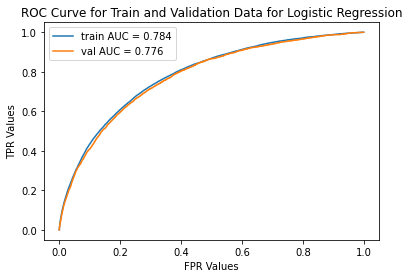

In [ ]:
# Plotting the ROC Curve
y_pred_train = batch_predict(model, scaler_train)
y_pred_val = batch_predict(model, scaler_val)

train_parameters , val_parameters = plot_roc_curve(y_train, y_pred_train, y_val, y_pred_val, 'Logistic Regression')

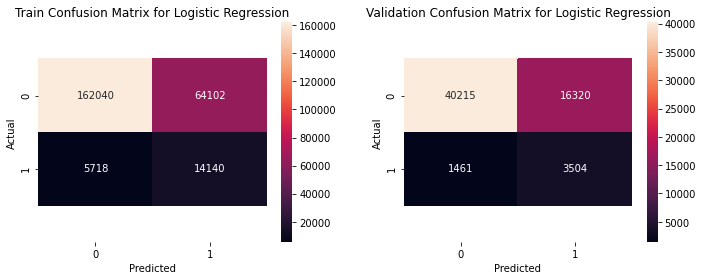

In [ ]:
# Plot the Confusion Matrix for both train and validation data

y_pred_abs_train = predict(y_pred_train, train_parameters['threshold'], train_parameters['fpr'], train_parameters['tpr'])
y_pred_abs_val = predict(y_pred_val, val_parameters['threshold'], val_parameters['fpr'], val_parameters['tpr'])

plot_conf_matrix(y_train, y_pred_abs_train, y_val, y_pred_abs_val)

In [ ]:
# Creating and storing the submission file for test data
y_pred_lr = model.predict_proba(scaled_test)[:, 1]
submit_lr = pd.read_csv(directory + 'sample_submission.csv')
submit_lr['TARGET'] = y_pred_lr
submit_lr.to_csv('logistic_regression_submission.csv', index = False)

After submitting this to Kaggle, I got a Leaderboard score of 0.767 which is pretty impressive for a simple Logistic Regression model.

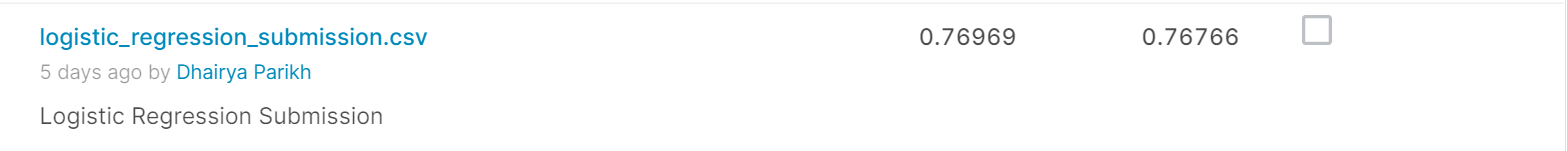

In [ ]:
# Now that we have completed everything, we will delete the model and variables to free memory
del model, submit_lr, train_parameters, val_parameters, y_pred_abs_train, y_pred_abs_val, y_pred_train, y_pred_val

### 3. Random Forest

For Random Forest, we will tune the model using a given set of parameters that I found while surfing through the discussions and online blogs for my research. 

We will be using Randomized Search CV for hyper parameter tuning but after testing it on colab, the system tends to run out of ram when doing so. I even tried to select the best features but that also faces the same RAM overflow issue.

So, I have used a Random Forest model I got from a public kernel of the competition.

In [ ]:
# Reference : https://www.kaggle.com/hamzaben/eda-random-forest-lightgbm-0-758
# The reference is for taking the tunes model parameters only.

model = RandomForestClassifier(n_estimators=200, 
                                      min_samples_split=10, 
                                      min_samples_leaf=5, 
                                      n_jobs=-1,
                                      verbose = 1, 
                                      random_state=42) 

model.fit(scaler_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 17.4min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      |

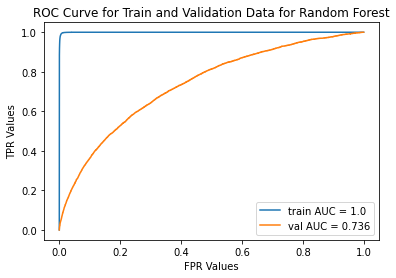

In [ ]:
# Getting the probablity predictions and plotting the ROC AUC Curve
y_pred_train = batch_predict(model, scaler_train)
y_pred_val = batch_predict(model, scaler_val)

train_parameters , val_parameters = plot_roc_curve(y_train, y_pred_train, y_val, y_pred_val, 'Random Forest')

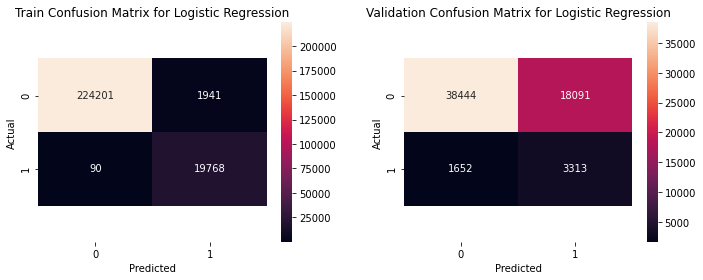

In [ ]:
# Plotting the train and val confusion matrix
y_pred_abs_train = predict(y_pred_train, train_parameters['threshold'], train_parameters['fpr'], train_parameters['tpr'])
y_pred_abs_val = predict(y_pred_val, val_parameters['threshold'], val_parameters['fpr'], val_parameters['tpr'])

plot_conf_matrix(y_train, y_pred_abs_train, y_val, y_pred_abs_val)

In [ ]:
# Creating and storing the submission file for test data
y_pred_lr = model.predict_proba(scaled_test)[:, 1]
submit_lr = pd.read_csv(directory + 'sample_submission.csv')
submit_lr['TARGET'] = y_pred_lr
submit_lr.to_csv('random_forest_submission.csv', index = False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.3s finished


After submitting the predictions on the Kaggle competition page, I got a Leaderboard score of 0.693 which is very less compared to simple logistic regression.
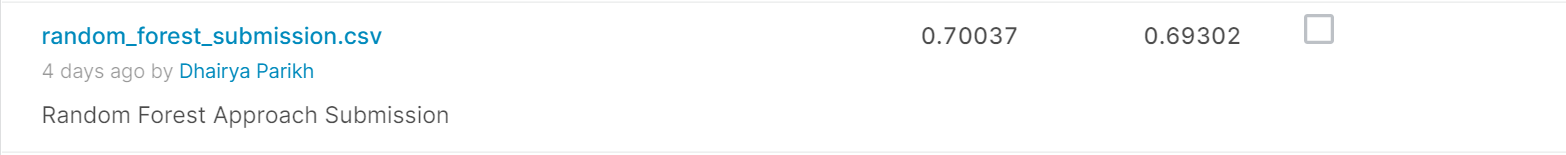

Hence, our best performing model is still Logistic Regression for C = 0.01

In [ ]:
# Now that we have completed everything, we will delete the model and variables to free memory
del model, submit_lr, train_parameters, val_parameters, y_pred_abs_train, y_pred_abs_val, y_pred_train, y_pred_val

### 4. LightGBM

For this model too, we will use an already tuned model because of the computational limitation we are facing. For that reason, I have not run the included Bayesian Optimization code as it takes over 12 hours for one full run. 

I ran it once and got the results, which are used in all the code related to LightGBM after that.

In [ ]:
# Reference : https://www.kaggle.com/returnofsputnik/bayes-opt-again/code
# Reference : https://www.dlology.com/blog/how-to-do-hyperparameter-search-with-baysian-optimization-for-keras-mode

# Please note that I could not run this as it would overflow the memory of the colab notebook so I have included this for reference.
# This will help you find the best parameters for your model.

data = lgb.Dataset(data=scaler_train, label=y_train)

def parameters(num_iterations,num_leaves, feature_fraction, max_depth, min_split_gain, min_child_weight,learning_rate):
  params = {'application':'binary','early_stopping_round':100, 'metric':'auc'}
  params['num_iterations']=int(round(num_iterations))
  params["num_leaves"] = int(round(num_leaves))
  params["learning_rate"] = learning_rate
  params['feature_fraction'] = max(min(feature_fraction, 1), 0)
  params['max_depth'] = int(round(max_depth))
  params['min_split_gain'] = min_split_gain
  params['min_child_weight'] = min_child_weight
  
  cv_result = lgb.cv(params, data, nfold=5,seed=6, stratified=True, metrics=['auc'])
  return max(cv_result['auc-mean'])

optimizer = BayesianOptimization(parameters, {'num_iterations':(9800,11000),
                                            'num_leaves':(16,48),
                                            'feature_fraction':(0.1,0.5),
                                            'max_depth': (6,12),
                                            'min_split_gain':(0.001,0.1),
                                            'min_child_weight': (20,60),
                                            'learning_rate':(0.01,0.07)                                   
                                            })
    
optimizer.maximize(init_points=30, n_iter=30)
    
print(optimizer.max) 


In [ ]:
# Parameters for our LGBM Classifier
lgbm_params = {
            'njobs': -1,
            'n_estimators': 10000,
            'learning_rate': .02,
            'num_leaves': 34,
            'colsample_bytree': .9497036,
            'subsample': .8715623,
            'max_depth': 7,
            'reg_alpha': .041545473,
            'reg_lambda': .0735294,
            'min_split_gain': .0222415,
            'min_child_weight': 39.3259775,
            'silent': -1,
            'verbose': -1,
            'device_type' : 'gpu'
}

In [ ]:
# After we get the tuned LGBM Model, we will do a 5 fold cross validation to get the best performance.
fold = StratifiedKFold(n_splits = 3, shuffle = True)
a = 0

importances = pd.DataFrame()
y = train_df['TARGET']

# Getting only the features. Excluding the ids and target column.
features = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
importances['features'] = features

# Getting the train and test data ready
X = train_df[features]
X_test = test_df[features]

X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

train_predict = np.zeros(train_df.shape[0])
cv_predict = np.zeros(train_df.shape[0])
test_predict = np.zeros(test_df.shape[0])

for i,(train, cv) in enumerate(fold.split(X,y)):
  X_train, Y_train = X.iloc[train], y.iloc[train]
  X_valid, Y_valid = X.iloc[cv], y.iloc[cv]

  model = LGBMClassifier(**lgbm_params)
  
  model.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)
  
  a=a+1

  train_predict[train] = model.predict_proba(X_train, num_iteration=model.best_iteration_)[:, 1]
  cv_predict[cv]=model.predict_proba(X_valid, num_iteration=model.best_iteration_)[:, 1]
  test_predict += model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1] / 5
  
  importances["imp"] = model.feature_importances_
  importances["fold"] = i + 1
  print('Fold ',i + 1,' TRAIN AUC : ',roc_auc_score(Y_train, train_predict[train]))
  print('Fold ',i + 1,' CV AUC : ',roc_auc_score(Y_valid, cv_predict[cv]))
        
  del X_train, Y_train, X_valid, Y_valid
  gc.collect()  

Full TRAIN AUC score  0.8803514245069372
Full CV AUC score  0.7916800427173107


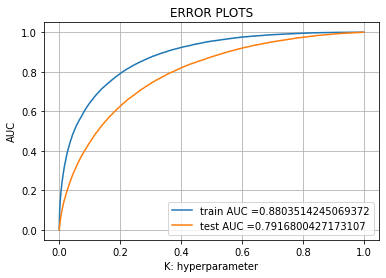

In [ ]:
print('Full TRAIN AUC score ',roc_auc_score(y, train_predict))
print('Full CV AUC score ',roc_auc_score(y, cv_predict))
    
train_fpr, train_tpr, tr_thresholds = roc_curve(y, train_predict)
test_fpr, test_tpr, te_thresholds = roc_curve(y, cv_predict)

#plot auc curve
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

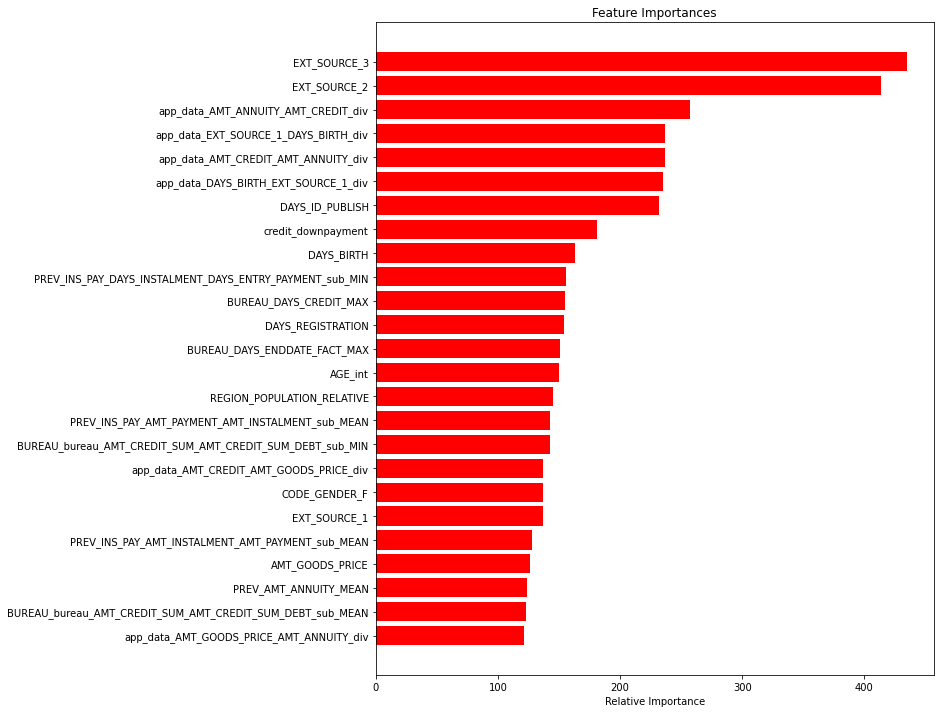

In [ ]:
#plot imp features
features = importances["features"]
importances = importances["imp"]
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# Trying to select the top 300 features using the feature importance. 
top_300_imp_values = (np.argsort(importances))[-300:]
final_features = [features[i] for i in top_300_imp_values]

In [ ]:
# Training a LGBM Model for the top features only. 
model = LGBMClassifier(**lgbm_params)

X_train, X_val, y_train, y_val = train_test_split(train_df[final_features], y, test_size = 0.2, stratify = y)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

Training until validation scores don't improve for 200 rounds.
[200]	training's binary_logloss: 0.233109	training's auc: 0.803324	valid_1's binary_logloss: 0.241608	valid_1's auc: 0.777057
[400]	training's binary_logloss: 0.222972	training's auc: 0.826455	valid_1's binary_logloss: 0.237659	valid_1's auc: 0.787325
[600]	training's binary_logloss: 0.216177	training's auc: 0.842766	valid_1's binary_logloss: 0.236418	valid_1's auc: 0.790794
[800]	training's binary_logloss: 0.210511	training's auc: 0.856062	valid_1's binary_logloss: 0.235869	valid_1's auc: 0.792223
[1000]	training's binary_logloss: 0.205566	training's auc: 0.867394	valid_1's binary_logloss: 0.235586	valid_1's auc: 0.792945
[1200]	training's binary_logloss: 0.200842	training's auc: 0.877708	valid_1's binary_logloss: 0.235455	valid_1's auc: 0.793232
[1400]	training's binary_logloss: 0.196439	training's auc: 0.88699	valid_1's binary_logloss: 0.23528	valid_1's auc: 0.793776
[1600]	training's binary_logloss: 0.192156	training's 

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.9497036, importance_type='split',
               learning_rate=0.02, max_depth=8, min_child_samples=20,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=10000, n_jobs=-1, nthread=4, num_leaves=34,
               objective=None, random_state=None, reg_alpha=0.041545473,
               reg_lambda=0.0735294, silent=-1, subsample=0.8715623,
               subsample_for_bin=200000, subsample_freq=0, verbose=-1)

In [ ]:
# Creating and storing the submission file for test data for all the features
y_pred_lgb = model.predict_proba(test_df[features])[:, 1]
submit_lgb = pd.read_csv(directory + 'sample_submission.csv')
submit_lgb['TARGET'] = y_pred_lgb
submit_lgb.to_csv('lgb_submission.csv', index = False)

In [ ]:
# Creating and storing the submission file for test data on top 300 features.
y_pred_lgb = model.predict_proba(test_df[final_features])[:, 1]
submit_lgb = pd.read_csv(directory + 'sample_submission.csv')
submit_lgb['TARGET'] = y_pred_lgb
submit_lgb.to_csv('lgb_submission_top300.csv', index = False)

We got a Leader Board Score of **0.79115** for the submission with all the features, which is a really good score! 

Then, the submission with the top 300 features also yields a score of **0.79008** which is note at all bad but still less than the previous score. 

Note that this is the only model which is trained on the original and not the normalized data. For some reason, the performance on the scaled data is not that good.

Next, we will try a stacking classifier which allows us to stack different models and see the performance by running a simple classifier on top of the perdictions of all the base models of stacking classifier. 

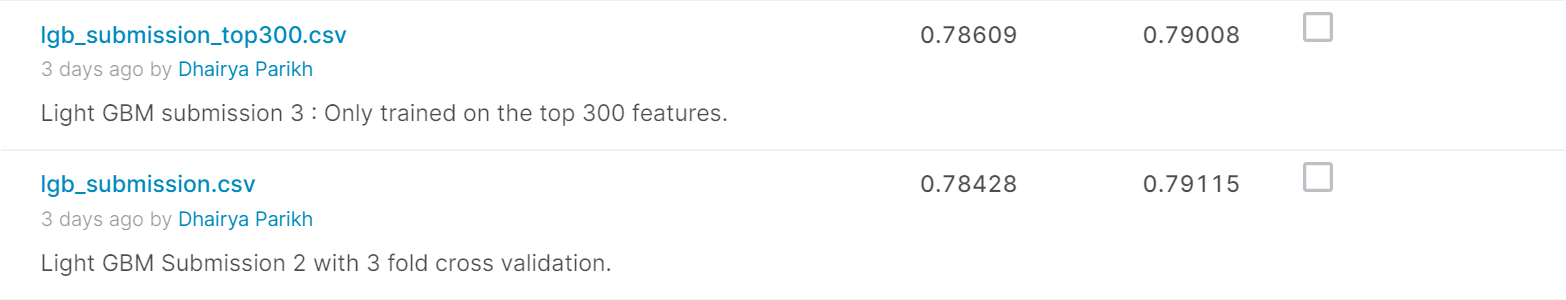

In [ ]:
# Freeing up the memory
del model, X_train, X_val, y_train, y_val

### 5. XGBoost

Next, we will test the XGBoost model for both the raw data and scaled or normalized data.

In [ ]:
#Initializing the XGBoost Model with GPU usage capability for faster training
model = XGBClassifier(learning_rate =0.01, n_estimators=10000, max_depth=4, min_child_weight=5, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', 
            nthread=4, scale_pos_weight=2.5, seed=27, reg_lambda = 1.2, verbose = 5, gpu_hist = 0, tree_method = 'gpu_hist')

In [ ]:
importances = pd.DataFrame()

# Getting only the features. Excluding the ids and target column.
features = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
importances['features'] = features
X = train_df[features]
Y = train_df['TARGET']

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, stratify = Y)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

importances["imp"] = model.feature_importances_


In [ ]:
# Plot the ROC Curve
train_predict = model.predict_proba(X_train)[:, 1]
cv_predict=model.predict_proba(X_val)[:, 1]

print('Full TRAIN AUC score ',roc_auc_score(y, train_predict))
print('Full CV AUC score ',roc_auc_score(y, cv_predict))
    
train_fpr, train_tpr, tr_thresholds = roc_curve(y, train_predict)
test_fpr, test_tpr, te_thresholds = roc_curve(y, cv_predict)

#plot auc curve
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS : XGBoost")
plt.grid()
plt.show()

In [ ]:
# Plot the Feature Importances
features = importances["features"]
importances = importances["imp"]
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# Creating a submission file for xgboost
y_pred_xgb = model_2.predict_proba(test_df[features])[:, 1]
submit_xgb = pd.read_csv(directory + 'sample_submission.csv')
submit_xgb['TARGET'] = y_pred_xgb
submit_xgb.to_csv('xgb_submission.csv', index = False)

Here are the Leaderboard stats for this model. We got our best performing model till now:

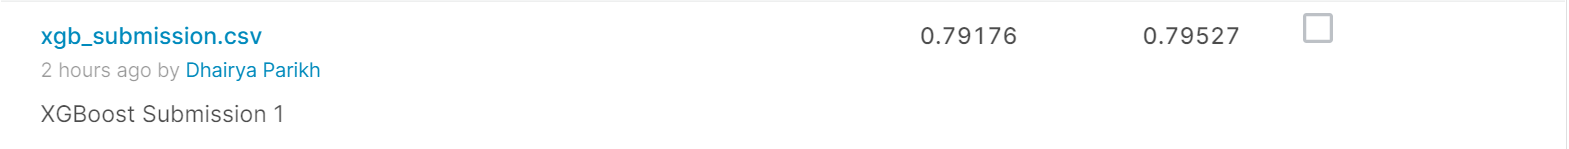

### 6. CatBoost

In [ ]:
# Model 3 : Cat_Boost Model
catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.01,
    'depth': 7,
    'l2_leaf_reg': 40,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.8,
    'scale_pos_weight': 5,
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'allow_writing_files': False,
    'task_type' : 'GPU',
     'devices' : '0:1'
}

model = CatBoostClassifier(**catboost_params)

In [ ]:
# Training the XGBoost Model
features = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df[features]
Y = train_df['TARGET']

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, stratify = Y)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

0:	learn: 0.7218671	test: 0.7142603	best: 0.7142603 (0)	total: 71.4ms	remaining: 1m 11s
1:	learn: 0.7252747	test: 0.7181757	best: 0.7181757 (1)	total: 122ms	remaining: 1m
2:	learn: 0.7292701	test: 0.7227969	best: 0.7227969 (2)	total: 169ms	remaining: 56.1s
3:	learn: 0.7291995	test: 0.7223633	best: 0.7227969 (2)	total: 215ms	remaining: 53.4s
4:	learn: 0.7315197	test: 0.7246935	best: 0.7246935 (4)	total: 259ms	remaining: 51.6s
5:	learn: 0.7312879	test: 0.7244496	best: 0.7246935 (4)	total: 305ms	remaining: 50.6s
6:	learn: 0.7314565	test: 0.7244051	best: 0.7246935 (4)	total: 350ms	remaining: 49.7s
7:	learn: 0.7313959	test: 0.7244447	best: 0.7246935 (4)	total: 395ms	remaining: 48.9s
8:	learn: 0.7322168	test: 0.7254866	best: 0.7254866 (8)	total: 440ms	remaining: 48.4s
9:	learn: 0.7323209	test: 0.7256375	best: 0.7256375 (9)	total: 486ms	remaining: 48.1s
10:	learn: 0.7331740	test: 0.7264168	best: 0.7264168 (10)	total: 532ms	remaining: 47.8s
11:	learn: 0.7334189	test: 0.7268691	best: 0.7268691 

In [ ]:
# Creating a submission file for catboost
y_pred_cb = model.predict_proba(test_df[features])[:, 1]
submit_cb = pd.read_csv(directory + 'sample_submission.csv')
submit_cb['TARGET'] = y_pred_cb
submit_cb.to_csv('cb_submission.csv', index = False)

This is the leaderboard score for the catboost model:

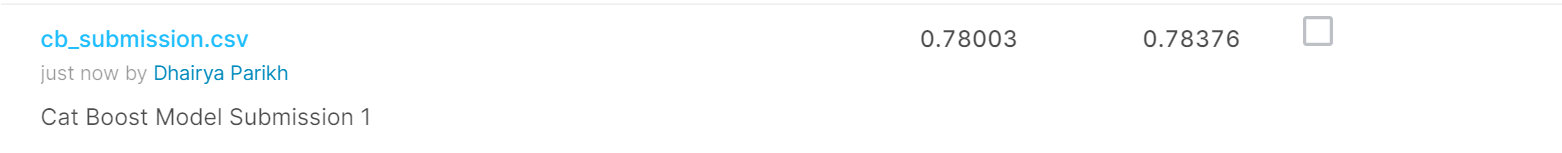

### 7. Stacking Classifier

For stacking, we will be using the following models:

1. The LightGBM Model we used in the previous Experiement.
2. A tuned XGBoost Model.
3. A Catboost model

For the Classifier we build on top of these based models, we will use Logistic Regression. 

In [ ]:
# Parameters for each base model
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# 1. LGBM Model 1
model_1_params = {
            'nthread': 4,
            'n_estimators': 10000,
            'learning_rate': .02,
            'num_leaves': 34,
            'colsample_bytree': .9497036,
            'subsample': .8715623,
            'max_depth': 8,
            'reg_alpha': .041545473,
            'reg_lambda': .0735294,
            'min_split_gain': .0222415,
            'min_child_weight': 39.3259775,
            'silent': -1,
            'verbose': -1
            }

model_1 = LGBMClassifier(**model_1_params)

#2.  XGBoost Model
model_2 = XGBClassifier(learning_rate =0.01, n_estimators=10000, max_depth=4, min_child_weight=5, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', 
            nthread=4, scale_pos_weight=2.5, seed=27, reg_lambda = 1.2, verbose = 5, gpu_hist = 0, tree_method = 'gpu_hist')

# Model 3 : Cat_Boost Model
catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.01,
    'depth': 7,
    'l2_leaf_reg': 40,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.8,
    'scale_pos_weight': 5,
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'allow_writing_files': False,
    'task_type' : 'GPU',
     'devices' : '0:1'
}

model_3 = CatBoostClassifier(**catboost_params)

meta_model = LogisticRegression(C = 0.01)

In [ ]:
# Initializing the Stacking Classifier
from mlxtend.classifier import StackingCVClassifier

stacked_clf = StackingCVClassifier(classifiers=[model_1, model_2, model_3], 
                            use_probas=True,
                            use_features_in_secondary=True,
                            meta_classifier=meta_model,
                            cv=3)

In [ ]:
# Testing the Stacking Classifier first
features = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df[features]
Y = train_df['TARGET']

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, stratify = Y)

stacked_clf.fit(X_train.values, y_train.values)

prediction = stacked_clf.predict_proba(X_val)
auc = roc_auc_score(y_val, prediction[:, 1])
print("The val AUC Score is : ",auc)

Due to some reason, I could not run this code snippet on colab. I kept the code running for 1 full day and still it kept running out of RAM. 

But if you have a powerful PC, please do test it. 

In [ ]:
# Seperating all the categorical columns
ss_fea = [f for f in df.columns if f.startswith('school_state')]
data_ss = df[ss_fea]

cc_fea = [f for f in df.columns if f.startswith('clean_categories')]
data_cc = df[cc_fea]

csc_fea = [f for f in df.columns if f.startswith('clean_subcategories')]
data_csc = df[csc_fea]

tp_fea = [f for f in df.columns if f.startswith('teacher_prefix')]
data_tp = df[tp_fea]

# Test data
pgc_fea = [f for f in df.columns if f.startswith('project_grade_category')]
data_pgc = df[pgc_fea]

# Test data
pgc_fea_test = [f for f in df_test.columns if f.startswith('project_grade_category')]
data_pgc_test = df_test[pgc_fea_test]

ss_fea_test = [f for f in df_test.columns if f.startswith('school_state')]
data_ss_test = df_test[ss_fea_test]

cc_fea_test = [f for f in df_test.columns if f.startswith('clean_categories')]
data_cc_test = df_test[cc_fea_test]

csc_fea_test = [f for f in df_test.columns if f.startswith('clean_subcategories')]
data_csc_test = df_test[csc_fea_test]

tp_fea_test = [f for f in df_test.columns if f.startswith('teacher_prefix')]
data_tp_test = df_test[tp_fea_test]

pgc_fea_test = [f for f in df_test.columns if f.startswith('project_grade_category')]
data_pgc_test = df_test[pgc_fea_test]


# This marks the end of this project.